<!-- Not content, but for better presentation styles -->
<style>
.rise-enabled .rendered_html table.dataframe {
    font-size: 12px;
}
.rendered_html code {
    background: #EFEFEF;
    border: 1px solid #CCC;
    padding: 1px 5px;
    border-radius: 1px;
}
.rise-enabled .fa-times-circle:before,
.rise-enabled .fa-question:before,
.rise-enabled aside.controls {
    opacity: 0.1;
}
.rise-enabled a,
.rise-enabled a:active,
.rise-enabled a:hover,
.rise-enabled a:visited,
.rise-enabled :link {
    text-decoration: none;
    color: #A68910;
}
</style>```

# Evolving Controllably Difficult Datasets for Clustering

An interactive notebook quickly exploring the paper <a href="https://dl.acm.org/doi/10.1145/3321707.3321761">Evolving Controllably Difficult Datasets for Clustering</a>.
Written by Cameron Shand, Richard  Allmendinger, Julia  Handl, Andrew  Webb, John A Keane. <a href="https://dl.acm.org/doi/10.1145/3321707.3321761">(more info about the authors here)</a>

- Part 1: Presentation of the paper


- Part 2: Simple examples using the associated Python package HAWKS

<a href="https://github.com/sea-shunned/hawks">HAWKS</a> is available on <a href="https://github.com/sea-shunned/hawks">GitHub</a>, and can be installed using <a href="https://pypi.org/project/hawks/">pip</a>
```
pip install hawks
```


## Introduction
Synthetic datasets play an important role in evaluating clustering algorithms, as they can help shed light on consistent biases, strengths,and weaknesses of particular techniques.

HAWKS is a Data generator that uses an evolutionary algorithm to evolve cluster structure of a synthetic data set.

**Main idea**: to produce datasets of a pre-specified difficulty, to trade off different aspects of problem difficulty

Influence the clustering perfomance of established algorithm.

Related work : 

<center><img src='img/Fig1.png'></center>

## Evolving cluster

### Representation
Each individual in the population represents a single dataset of dimensionality D, and (at present) each cluster is described by a multivariate Gaussian.

Each Gaussian is defined by two (sets of) decision variables: 
- a D ×1 vector describing its mean: μ
- the associated D × D covariance matrix: Σ. 

K is the number of clusters and the length of the genotype is thus 2K

<center><img src='img/Fig2.png'></center>

### Objective 
<font size="4">

Maximize the silhouette width i.e. the cluster validity index. 
![Form 1](img/Formula1.png)
    
- a(i) represents the average intra-cluster distance for data point i and is the average distance from i to all other points in the cluster. 
- b(i) represents the inter-cluster distance; for data point i this is defined as the minimum of the average distances to all points in every other cluster.

![Form 2](img/Formula2.png) 

This provides a value in the range [−1, 1], where the **maximum represents very compact and well-separated clusters**. A negative silhouette width value indicates that points in different clusters are not well-separated (and their membership should be changed).
</font>


To better obtain solutions of a desired silhouette width, we specify a target silhouette width (s_t), and the objective (fitness) is to minimize the absolute difference between $s_t$ and $s_{all}$:

$$\min f(\mu_1,\Sigma_1,...,\mu_K,\Sigma_K)=\left | s_t −s_{all} \right |$$

## Evolutionary algorithm 

- Crossover 
- Mutation 
- Eccentricity constraint
- Overlap constraint



### Crossover

<center><img src='img/Fig3.png'></center>

To enhance diversity an uniform crossover is used. Treating $\mu$ and $\Sigma$ as a single unit can results in a lake of diversity.

### Mutation

The mean and covariance parts of the genotype are handled separately with a mutation rate set to $\frac{1}{K}$:

#### Mean mutation

 $\mu_{k}^{new} \sim \it{N}(\mu_{k}^{curr},s)$, New mean vectors are sampled from a Gaussian around current vectors.

#### Covariance mutation

For a given covariance matrix $\Sigma$ we can write $D,P$ such as $\Sigma = PDP^{T}$ and $D$ is the diagonal matrix of the eigenvalues of $\Sigma$ and $P$ the matrix of associated eigenvectors. The mutation of $\Sigma$ aims to modify $D,P$ by applying a transformation matrix. This transformation matrix is comprised of a scaling and rotation matrix. The scaling matrix aims to randomly modify eigenvalues and the rotation matrix aims to modify eigenvectors.

- The scaling matrix modifies $\Sigma$ by maintening $det(\Sigma)$ in order to preserve the volume of the ellipsoid
- The rotation matrix is created as the initial orientation matrix but raised to a given power to ensure that there are similarities from one generation to the next one.

### Constraints
Two constraints are added to improve the algorithm. These constraints provide additionnal control over the complexity of cluster structures and the direct modulation of potential trade-offs.

#### Eccentricity constraint
The eigenvalues of $\Sigma$ directly specify the eccentricity of a given cluster. To control this eccentricity the $\lambda$ ratio between the smallest and largest eigenvalue is calculated.

$$\lambda^{ratio} = \max\limits_{\forall k \in \{ 1,2...,K\}} \frac{max_{\forall i \in \{ 1,2...,K\}} \Sigma_{i,i}^{k}}{min_{\forall i \in \{ 1,2...,K\}} \Sigma_{i,i}^{k}}$$

#### Overlap constraint
As real-world problem can have clusters that overlap because of noise, a minimum amount of overlap is enforced. To do so the overlap is defined as,


$$ overlap = 1 - \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}_{C^i}(i_{nn})$$


where $i_{nn}$ is $i$'s nearest neighbour and $C^i$ is the cluster that data point $i$ belongs to.

<center><img src='img/Fig4.png'></center>

### Evolution of the clusters on 50 generation

<center><img src="https://raw.githubusercontent.com/sea-shunned/hawks/master/docs/source/images/hawks_animation.gif"></center>

## Part 2: Examples using HAWKS

A Python package <a href="https://github.com/sea-shunned/hawks">hawks</a> is available, it can be installed using pip
```
pip install hawks
```

In [33]:
# !pip install hawks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import math
from IPython.display import display
from sklearn import datasets as sk_datasets
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering

In [2]:
import hawks # package from the author of the paper
from hawks.genotype import Genotype

In [3]:
n_samples = 1000
# Set the magic seed number
SEED_NUM = 42
# Set the seed number in the config
config = {
    "hawks": {
        "seed_num": SEED_NUM,
        "num_runs": 1,
    },
     "objectives": {
        "silhouette": {
            "target": 0.9 # default is 8
        }
    },
    "dataset": {
        "num_clusters": 4, # default is 10
        "num_examples": n_samples, # default is 1000
    },
    "ga": {
        "num_gens": 50,
        "prob_fitness": 0.5,
    },
    "constraints": {
        "overlap": {
            "threshold": 0.0,
            "limit": "upper"
        },
        "eigenval_ratio": {
            "threshold": 1000,
            "limit": "upper"
        }
    }
}
# Any missing parameters will take from hawks/defaults.json


In [192]:
generator = hawks.create_generator(config)
# Run the generator
generator.run()
# Get the best dataset found and it's labels
datasets, label_sets = generator.get_best_dataset()
hawks_set = (datasets[0], label_sets[0]) # Stored as a list for multiple runs

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:09,  5.11it/s]

Generations:   4%|▍         | 2/49 [00:00<00:08,  5.41it/s]

Generations:   6%|▌         | 3/49 [00:00<00:08,  5.62it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  5.82it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.84it/s]

Generations:  12%|█▏        | 6/49 [00:00<00:07,  6.04it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:06,  6.24it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:06,  6.16it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  6.23it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  6.30it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:05,  6.38it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:05,  6.24it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.48it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:05,  6.27it/s]

Generations:  31%|███       | 15/49 [00:02<

In [186]:
# Generate some datasets with different methods
circles = sk_datasets.make_circles(n_samples=n_samples, factor=0.5, noise=.05)
blobs = sk_datasets.make_blobs(n_samples=n_samples, random_state=8, centers=4)

labels = ['scikit-learn ‘circles’', 'scikit-learn ‘blobs’', "HAWKS"]
sets = [circles, blobs, hawks_set]

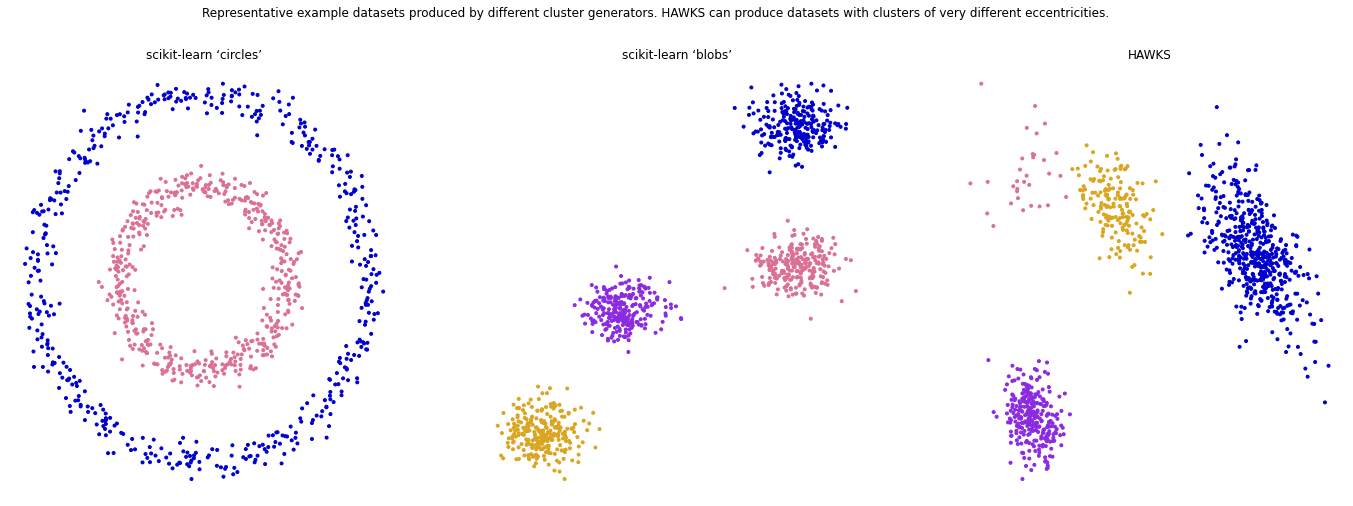

In [196]:
ncol = 3
fig, axs = plt.subplots(1, ncol, figsize=(24,8))
fig.suptitle("Representative example datasets produced by different cluster generators. HAWKS can produce datasets with clusters of very different eccentricities.")
colors = np.array(['mediumblue', 'palevioletred', 'goldenrod', 'blueviolet'])

for i, (data, label) in enumerate(zip(sets, labels)):
    X, y = data
    ax = axs[i%ncol]
    ax.scatter(X[:, 0], X[:, 1], color=colors[y], marker='.')
    ax.set_title(label)
    ax.axis('off')

## Congif variation

In [5]:
def plot_pop_configs(generator, params_tested, title):
    best_indivs = [ b[0] for b in generator.best_each_run]
    nb_config = len(best_indivs)
    df_best = generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")
    fig, axs = plt.subplots(1,nb_config, figsize=(20, 6))
    fig.suptitle(title,  y=1.05)
    for i, indiv in enumerate(best_indivs):
        ax = axs[i]
        hawks.plotting.plot_indiv(indiv, ax=ax, multiple=True)
        axtitle = "\n".join([f"{param_tested}={df_best.loc[i][param_tested]}" for param_tested in params_tested])
        ax.set_title(axtitle, wrap=True)
    fig.tight_layout()

In [55]:
# Try three different silhouette width target values
SEED_NUM = 21
config = {
    "hawks": {
        "seed_num": SEED_NUM
    },
    "objectives": {
        "silhouette": {
            "target": [0.2, 0.5, 0.8]
        }
    },
    "dataset": {
        "num_clusters": [4]
    }
}
# Any missing parameters will take from hawks/defaults.json
generator = hawks.create_generator(config)
# Run the generator
generator.run()

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:08,  5.44it/s]

Generations:   4%|▍         | 2/49 [00:00<00:08,  5.53it/s]

Generations:   6%|▌         | 3/49 [00:00<00:08,  5.63it/s]

Generations:   8%|▊         | 4/49 [00:00<00:08,  5.60it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.58it/s]

Generations:  12%|█▏        | 6/49 [00:01<00:07,  5.62it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.84it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:07,  5.82it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  5.82it/s]

Generations:  20%|██        | 10/49 [00:01<00:07,  5.53it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  5.93it/s]

Generations:  24%|██▍       | 12/49 [00:02<00:06,  5.72it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:06,  5.64it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:06,  5.53it/s]

Generations:  31%|███       | 15/49 [00:02<

Generations:  27%|██▋       | 13/49 [00:02<00:06,  5.70it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:06,  5.75it/s]

Generations:  31%|███       | 15/49 [00:02<00:05,  6.00it/s]

Generations:  33%|███▎      | 16/49 [00:02<00:05,  5.82it/s]

Generations:  35%|███▍      | 17/49 [00:02<00:05,  5.97it/s]

Generations:  37%|███▋      | 18/49 [00:02<00:05,  6.16it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:05,  5.88it/s]

Generations:  41%|████      | 20/49 [00:03<00:04,  5.93it/s]

Generations:  43%|████▎     | 21/49 [00:03<00:04,  5.91it/s]

Generations:  45%|████▍     | 22/49 [00:03<00:04,  5.82it/s]

Generations:  47%|████▋     | 23/49 [00:03<00:04,  5.85it/s]

Generations:  49%|████▉     | 24/49 [00:04<00:04,  5.84it/s]

Generations:  51%|█████     | 25/49 [00:04<00:04,  5.83it/s]

Generations:  53%|█████▎    | 26/49 [00:04<00:03,  5.75it/s]

Generations:  55%|█████▌    | 27/49 [00:04<00:03,  5.75it/s]

Generations:  57%|█████▋    | 28/49 [00:04<00:03,  5.97it/s]

Generati

In [56]:
generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")

,silhouette_target,num_clusters,run,indiv,gen,silhouette,fitness_silhouette,eigenval_ratio,overlap,best_indiv
config_id,,,,,,,,,,
0,0.2,4,0,7,49,0.204597,0.004597,17.746130,0.067,1
1,0.5,4,0,9,49,0.482327,0.017673,7.740902,0.112,1
2,0.8,4,0,1,49,0.799755,0.000245,16.840999,0.000,1


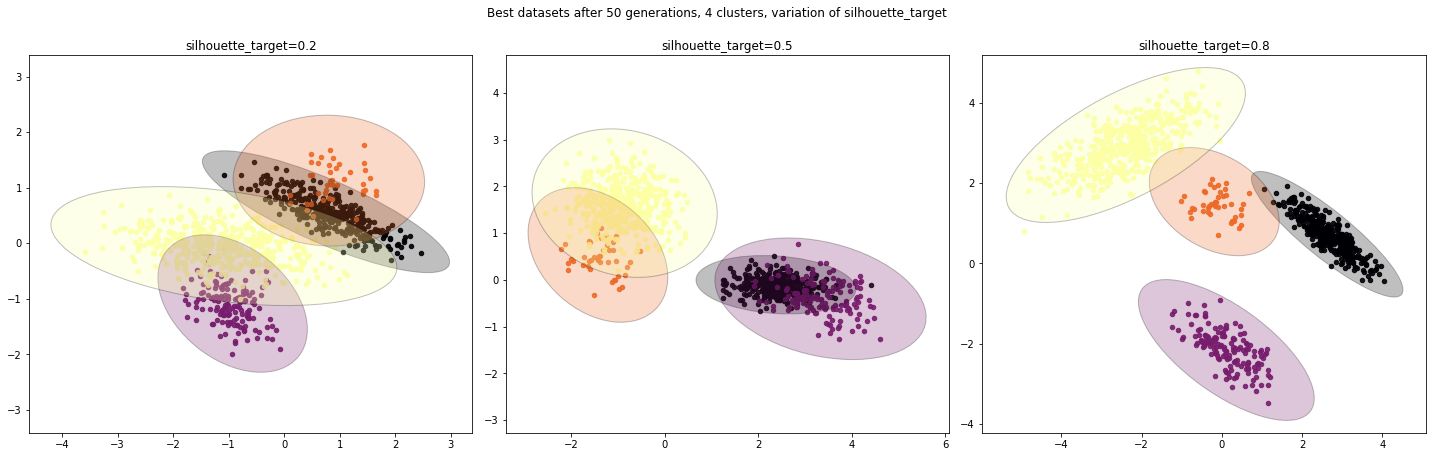

In [57]:
plot_pop_configs(generator, ["silhouette_target"], "Best datasets after 50 generations, 4 clusters, variation of silhouette_target")

In [224]:
# Try three different overlap_threshold target values
config = {
    "hawks": {
        "seed_num": SEED_NUM
    },
    "objectives": {
        "silhouette": {
            "target": 0.8
        }
    },
    "dataset": {
        "num_clusters": [4]
    },
    "constraints": {
        "overlap": {
            "threshold": [0.0, 0.2, 0.5],
            "limit": "upper"
        },
        "eigenval_ratio": {
            "threshold": 20,
            "limit": "upper"
        }
    }
}
# Any missing parameters will take from hawks/defaults.json
generator = hawks.create_generator(config)
# Run the generator
generator.run()

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:08,  5.47it/s]

Generations:   4%|▍         | 2/49 [00:00<00:08,  5.73it/s]

Generations:   6%|▌         | 3/49 [00:00<00:07,  5.86it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  5.99it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.85it/s]

Generations:  12%|█▏        | 6/49 [00:00<00:07,  5.97it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.96it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:06,  6.00it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  6.02it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  5.96it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  6.17it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:05,  6.18it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.26it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:05,  6.25it/s]

Generations:  31%|███       | 15/49 [00:02<

In [225]:
generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")

,num_clusters,overlap_threshold,run,indiv,gen,silhouette,fitness_silhouette,eigenval_ratio,overlap,best_indiv
config_id,,,,,,,,,,
0,4,0.0,0,0,49,0.799324,0.000676,10.245577,0.000999,1
1,4,0.2,0,0,49,0.799989,0.000011,18.774011,0.039960,1
2,4,0.5,0,3,49,0.800066,0.000066,9.422446,0.007992,1


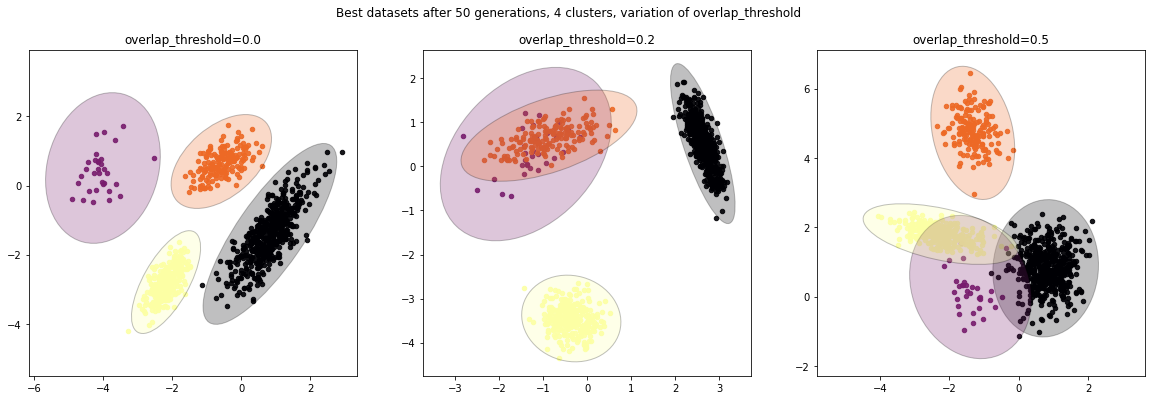

In [227]:
plot_pop_configs(generator, ["overlap_threshold"], "Best datasets after 50 generations, 4 clusters, silhouette_target=0.8, variation of overlap_threshold")

### Relation between the average silhouette width $s_{all}$ and $overlap$

<center><img src='img/Fig5.png'></center>

In [233]:
# Try two different overlap_threshold and two eigenval_ratio_limit target values
config = {
    "hawks": {
        "seed_num": SEED_NUM
    },
    "objectives": {
        "silhouette": {
            "target": 0.8
        }
    },
    "dataset": {
        "num_clusters": [4]
    },
    "constraints": {
        "overlap": {
            "threshold": [0.0, 0.5],
            "limit": "upper"
        },
        "eigenval_ratio": {
            "threshold": 20,
            "limit": ["upper", "lower"]
        }
    }
}
# Any missing parameters will take from hawks/defaults.json
generator = hawks.create_generator(config)
# Run the generator
generator.run()

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:10,  4.80it/s]

Generations:   4%|▍         | 2/49 [00:00<00:09,  5.17it/s]

Generations:   6%|▌         | 3/49 [00:00<00:08,  5.48it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  5.71it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.76it/s]

Generations:  12%|█▏        | 6/49 [00:01<00:07,  5.97it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.99it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:06,  6.01it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  6.02it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  5.96it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  6.13it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:05,  6.21it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.38it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:05,  6.39it/s]

Generations:  31%|███       | 15/49 [00:02<

In [234]:
generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")

,num_clusters,overlap_threshold,eigenval_ratio_limit,run,indiv,gen,silhouette,fitness_silhouette,eigenval_ratio,overlap,best_indiv
config_id,,,,,,,,,,,
0,4,0.0,upper,0,0,49,0.799324,0.000676,10.245577,0.000999,1
1,4,0.0,lower,0,0,49,0.802603,0.002603,118.238460,0.006993,1
2,4,0.5,upper,0,3,49,0.800066,0.000066,9.422446,0.007992,1
3,4,0.5,lower,0,0,49,0.800012,0.000012,104.501522,0.006993,1


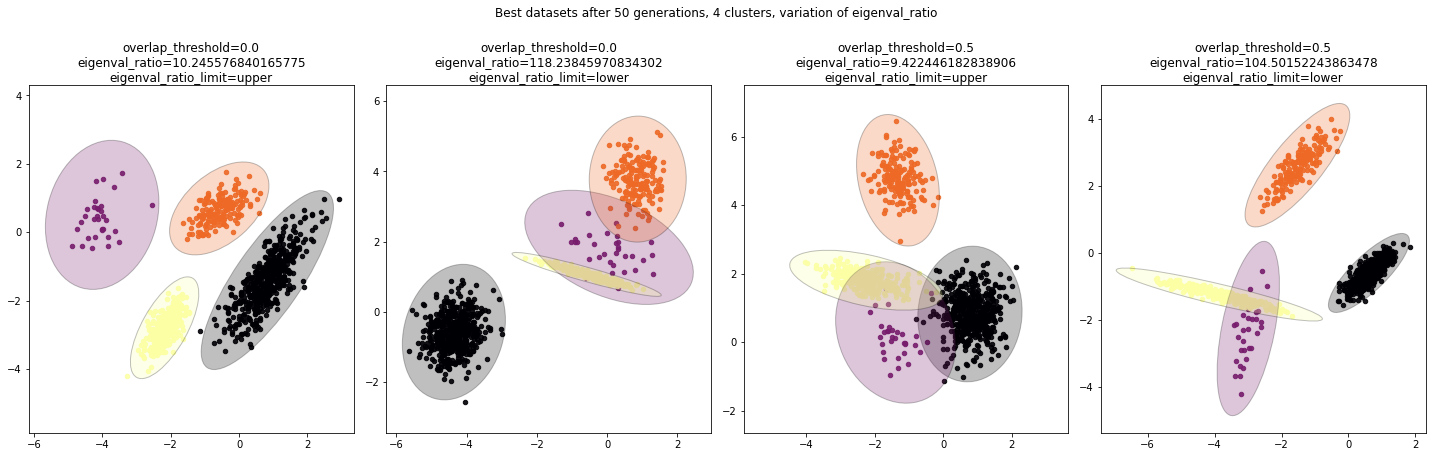

In [243]:
plot_pop_configs(generator, ["overlap_threshold", "eigenval_ratio", "eigenval_ratio_limit"], 
                 "Best datasets after 50 generations, 4 clusters, variation of eigenval_ratio")


# Visualisation of the increased difficulty

In [18]:
#silhouette
SEED_NUM = 12

silhouettes = np.linspace(0.35,0.85,num=30,endpoint = False)
kmeans_scores = []
linkage_scores = []

for st in silhouettes:
    config = {
    "hawks": {
        "folder_name": "simple_example",
        "seed_num": SEED_NUM
    },
    "dataset": {
        "num_examples": 700,
        "num_clusters": 5
    },
    "objectives": {
        "silhouette": {
            "target": st
        }
    }
    }
    generator = hawks.create_generator(config)
    generator.run()
    datasets, label_sets = generator.get_best_dataset()
    data, labels = datasets[0], label_sets[0] # Stored as a list for multiple runs
    # Run KMeans on the data
    km = KMeans(n_clusters=len(np.unique(labels)), random_state=SEED_NUM).fit(data)
    ac = AgglomerativeClustering(n_clusters=len(np.unique(labels))).fit(data)
    
    kmeans_scores.append(adjusted_rand_score(labels, km.labels_))
    linkage_scores.append(adjusted_rand_score(labels, ac.labels_))

Runs:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Generations:   0%|                                                                              | 0/49 [00:00<?, ?it/s]

Generations:   2%|█▍                                                                    | 1/49 [00:00<00:11,  4.22it/s]

Generations:   4%|██▊                                                                   | 2/49 [00:00<00:10,  4.30it/s]

Generations:   6%|████▎                                                                 | 3/49 [00:00<00:10,  4.40it/s]

Generations:   8%|█████▋                                                                | 4/49 [00:00<00:10,  4.39it/s]

Generations:  10%|███████▏                                                              | 5/49 [00:01<00:11,  3.97it/s]

Generations:  12%|████████▌                                                             | 6/49 [00:01<00:11,  3.80it/s]

Generations:  14%|██████████    

Generations:  33%|██████████████████████▌                                              | 16/49 [00:03<00:08,  4.02it/s]

Generations:  35%|███████████████████████▉                                             | 17/49 [00:04<00:07,  4.03it/s]

Generations:  37%|█████████████████████████▎                                           | 18/49 [00:04<00:07,  4.15it/s]

Generations:  39%|██████████████████████████▊                                          | 19/49 [00:04<00:07,  4.15it/s]

Generations:  41%|████████████████████████████▏                                        | 20/49 [00:04<00:06,  4.25it/s]

Generations:  43%|█████████████████████████████▌                                       | 21/49 [00:04<00:06,  4.32it/s]

Generations:  45%|██████████████████████████████▉                                      | 22/49 [00:05<00:07,  3.78it/s]

Generations:  47%|████████████████████████████████▍                                    | 23/49 [00:05<00:06,  4.07it/s]

Generations:  49%|██████████████

Generations:  69%|███████████████████████████████████████████████▉                     | 34/49 [00:07<00:02,  5.08it/s]

Generations:  71%|█████████████████████████████████████████████████▎                   | 35/49 [00:07<00:02,  4.90it/s]

Generations:  73%|██████████████████████████████████████████████████▋                  | 36/49 [00:07<00:02,  5.14it/s]

Generations:  76%|████████████████████████████████████████████████████                 | 37/49 [00:07<00:02,  5.07it/s]

Generations:  78%|█████████████████████████████████████████████████████▌               | 38/49 [00:07<00:02,  4.91it/s]

Generations:  80%|██████████████████████████████████████████████████████▉              | 39/49 [00:08<00:02,  4.99it/s]

Generations:  82%|████████████████████████████████████████████████████████▎            | 40/49 [00:08<00:01,  5.00it/s]

Generations:  84%|█████████████████████████████████████████████████████████▋           | 41/49 [00:08<00:01,  5.22it/s]

Generations:  86%|██████████████

Runs:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Generations:   0%|                                                                              | 0/49 [00:00<?, ?it/s]

Generations:   2%|█▍                                                                    | 1/49 [00:00<00:09,  4.92it/s]

Generations:   4%|██▊                                                                   | 2/49 [00:00<00:09,  4.91it/s]

Generations:   6%|████▎                                                                 | 3/49 [00:00<00:08,  5.15it/s]

Generations:   8%|█████▋                                                                | 4/49 [00:00<00:08,  5.08it/s]

Generations:  10%|███████▏                                                              | 5/49 [00:01<00:08,  4.90it/s]

Generations:  12%|████████▌                                                             | 6/49 [00:01<00:08,  4.97it/s]

Generations:  14%|██████████    

Generations:  31%|█████████████████████                                                | 15/49 [00:02<00:06,  4.93it/s]

Generations:  33%|██████████████████████▌                                              | 16/49 [00:03<00:06,  5.17it/s]

Generations:  35%|███████████████████████▉                                             | 17/49 [00:03<00:06,  5.06it/s]

Generations:  37%|█████████████████████████▎                                           | 18/49 [00:03<00:06,  5.14it/s]

Generations:  39%|██████████████████████████▊                                          | 19/49 [00:03<00:06,  5.00it/s]

Generations:  41%|████████████████████████████▏                                        | 20/49 [00:03<00:05,  5.15it/s]

Generations:  43%|█████████████████████████████▌                                       | 21/49 [00:04<00:05,  5.20it/s]

Generations:  45%|██████████████████████████████▉                                      | 22/49 [00:04<00:05,  5.10it/s]

Generations:  47%|██████████████

Generations:  67%|██████████████████████████████████████████████▍                      | 33/49 [00:06<00:03,  5.03it/s]

Generations:  69%|███████████████████████████████████████████████▉                     | 34/49 [00:06<00:03,  4.98it/s]

Generations:  71%|█████████████████████████████████████████████████▎                   | 35/49 [00:06<00:02,  4.96it/s]

Generations:  73%|██████████████████████████████████████████████████▋                  | 36/49 [00:07<00:02,  4.95it/s]

Generations:  76%|████████████████████████████████████████████████████                 | 37/49 [00:07<00:02,  5.05it/s]

Generations:  78%|█████████████████████████████████████████████████████▌               | 38/49 [00:07<00:02,  5.01it/s]

Generations:  80%|██████████████████████████████████████████████████████▉              | 39/49 [00:07<00:01,  5.08it/s]

Generations:  82%|████████████████████████████████████████████████████████▎            | 40/49 [00:07<00:01,  5.03it/s]

Generations:  84%|██████████████

Runs:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Generations:   0%|                                                                              | 0/49 [00:00<?, ?it/s]

Generations:   2%|█▍                                                                    | 1/49 [00:00<00:09,  4.92it/s]

Generations:   4%|██▊                                                                   | 2/49 [00:00<00:09,  4.88it/s]

Generations:   6%|████▎                                                                 | 3/49 [00:00<00:08,  5.15it/s]

Generations:   8%|█████▋                                                                | 4/49 [00:00<00:08,  5.08it/s]

Generations:  10%|███████▏                                                              | 5/49 [00:01<00:08,  4.91it/s]

Generations:  12%|████████▌                                                             | 6/49 [00:01<00:08,  4.92it/s]

Generations:  14%|██████████    

Generations:  29%|███████████████████▋                                                 | 14/49 [00:02<00:07,  4.57it/s]

Generations:  31%|█████████████████████                                                | 15/49 [00:03<00:08,  4.13it/s]

Generations:  33%|██████████████████████▌                                              | 16/49 [00:03<00:07,  4.22it/s]

Generations:  35%|███████████████████████▉                                             | 17/49 [00:03<00:07,  4.30it/s]

Generations:  37%|█████████████████████████▎                                           | 18/49 [00:03<00:07,  4.41it/s]

Generations:  39%|██████████████████████████▊                                          | 19/49 [00:03<00:06,  4.56it/s]

Generations:  41%|████████████████████████████▏                                        | 20/49 [00:04<00:06,  4.62it/s]

Generations:  43%|█████████████████████████████▌                                       | 21/49 [00:04<00:06,  4.64it/s]

Generations:  45%|██████████████

Generations:  65%|█████████████████████████████████████████████                        | 32/49 [00:06<00:03,  4.82it/s]

Generations:  67%|██████████████████████████████████████████████▍                      | 33/49 [00:07<00:03,  4.88it/s]

Generations:  69%|███████████████████████████████████████████████▉                     | 34/49 [00:07<00:03,  4.81it/s]

Generations:  71%|█████████████████████████████████████████████████▎                   | 35/49 [00:07<00:02,  4.85it/s]

Generations:  73%|██████████████████████████████████████████████████▋                  | 36/49 [00:07<00:02,  4.85it/s]

Generations:  76%|████████████████████████████████████████████████████                 | 37/49 [00:08<00:02,  4.83it/s]

Generations:  78%|█████████████████████████████████████████████████████▌               | 38/49 [00:08<00:02,  4.88it/s]

Generations:  80%|██████████████████████████████████████████████████████▉              | 39/49 [00:08<00:02,  4.89it/s]

Generations:  82%|██████████████

                                                                                                                       
Runs:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Generations:   0%|                                                                              | 0/49 [00:00<?, ?it/s]

Generations:   2%|█▍                                                                    | 1/49 [00:00<00:10,  4.67it/s]

Generations:   4%|██▊                                                                   | 2/49 [00:00<00:09,  4.82it/s]

Generations:   6%|████▎                                                                 | 3/49 [00:00<00:09,  4.99it/s]

Generations:   8%|█████▋                                                                | 4/49 [00:00<00:09,  4.85it/s]

Generations:  10%|███████▏                                                              | 5/49 [00:01<00:09,  4.81it/s]

Generations:  12%|████████▌      

Generations:  27%|██████████████████▎                                                  | 13/49 [00:02<00:07,  4.83it/s]

Generations:  29%|███████████████████▋                                                 | 14/49 [00:02<00:07,  4.73it/s]

Generations:  31%|█████████████████████                                                | 15/49 [00:03<00:07,  4.85it/s]

Generations:  33%|██████████████████████▌                                              | 16/49 [00:03<00:06,  4.78it/s]

Generations:  35%|███████████████████████▉                                             | 17/49 [00:03<00:06,  5.07it/s]

Generations:  37%|█████████████████████████▎                                           | 18/49 [00:03<00:06,  4.82it/s]

Generations:  39%|██████████████████████████▊                                          | 19/49 [00:03<00:06,  4.85it/s]

Generations:  41%|████████████████████████████▏                                        | 20/49 [00:04<00:05,  4.93it/s]

Generations:  43%|██████████████

Generations:  63%|███████████████████████████████████████████▋                         | 31/49 [00:06<00:03,  4.74it/s]

Generations:  65%|█████████████████████████████████████████████                        | 32/49 [00:06<00:03,  4.70it/s]

Generations:  67%|██████████████████████████████████████████████▍                      | 33/49 [00:07<00:03,  4.75it/s]

Generations:  69%|███████████████████████████████████████████████▉                     | 34/49 [00:07<00:03,  4.86it/s]

Generations:  71%|█████████████████████████████████████████████████▎                   | 35/49 [00:07<00:02,  4.81it/s]

Generations:  73%|██████████████████████████████████████████████████▋                  | 36/49 [00:07<00:02,  4.96it/s]

Generations:  76%|████████████████████████████████████████████████████                 | 37/49 [00:07<00:02,  4.97it/s]

Generations:  78%|█████████████████████████████████████████████████████▌               | 38/49 [00:08<00:02,  4.95it/s]

Generations:  80%|██████████████

Generations: 100%|█████████████████████████████████████████████████████████████████████| 49/49 [00:10<00:00,  4.94it/s]

                                                                                                                       
Runs:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Generations:   0%|                                                                              | 0/49 [00:00<?, ?it/s]

Generations:   2%|█▍                                                                    | 1/49 [00:00<00:10,  4.73it/s]

Generations:   4%|██▊                                                                   | 2/49 [00:00<00:09,  4.81it/s]

Generations:   6%|████▎                                                                 | 3/49 [00:00<00:09,  4.93it/s]

Generations:   8%|█████▋                                                                | 4/49 [00:00<00:09,  4.90it/s]

Generations:  10%|███████▏       

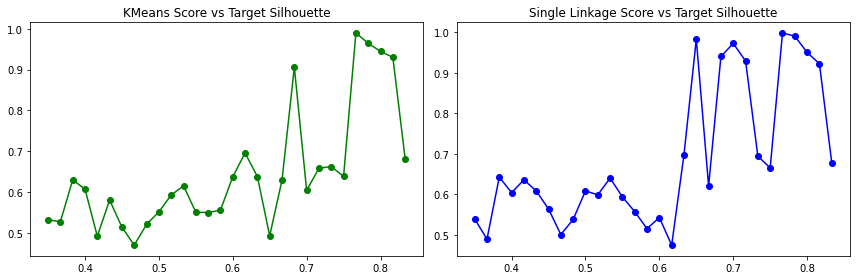

In [19]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].plot(silhouettes, kmeans_scores,'go-')
axs[0].set_title('KMeans Score vs Target Silhouette')
axs[1].plot(silhouettes, linkage_scores, 'bo-')
axs[1].set_title('Single Linkage Score vs Target Silhouette')
fig.tight_layout();

In [20]:
#eccentricity

eccentricity = np.linspace(5.,125.,num=20,endpoint = False)
kmeans_scores = []
linkage_scores = []

for e in eccentricity:
    config = {
    "hawks": {
        "folder_name": "simple_example",
        "seed_num": SEED_NUM
    },
    "dataset": {
        "num_examples": 700,
        "num_clusters": 5
    },
    "constraints": {
        "eigenval_ratio": {
            "threshold": e
        }
    }
    }
    generator = hawks.create_generator(config)
    generator.run()
    datasets, label_sets = generator.get_best_dataset()
    # Stored as a list for multiple runs
    data, labels = datasets[0], label_sets[0]
    # Run KMeans on the data
    km = KMeans(
    n_clusters=len(np.unique(labels)), random_state=SEED_NUM
    ).fit(data)
    ac = AgglomerativeClustering(
    n_clusters=len(np.unique(labels))).fit(data)
    
    kmeans_scores.append(adjusted_rand_score(labels, km.labels_))
    linkage_scores.append(adjusted_rand_score(labels, ac.labels_))
    


Runs:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Generations:   0%|                                                                              | 0/49 [00:00<?, ?it/s]

Generations:   2%|█▍                                                                    | 1/49 [00:00<00:12,  3.85it/s]

Generations:   4%|██▊                                                                   | 2/49 [00:00<00:11,  3.93it/s]

Generations:   6%|████▎                                                                 | 3/49 [00:00<00:11,  3.93it/s]

Generations:   8%|█████▋                                                                | 4/49 [00:01<00:11,  3.98it/s]

Generations:  10%|███████▏                                                              | 5/49 [00:01<00:11,  3.77it/s]

Generations:  12%|████████▌                                                             | 6/49 [00:01<00:12,  3.58it/s]

Generations:  14%|██████████    

Generations:  33%|██████████████████████▌                                              | 16/49 [00:04<00:08,  3.80it/s]

Generations:  35%|███████████████████████▉                                             | 17/49 [00:04<00:08,  3.90it/s]

Generations:  37%|█████████████████████████▎                                           | 18/49 [00:04<00:08,  3.83it/s]

Generations:  39%|██████████████████████████▊                                          | 19/49 [00:04<00:07,  4.05it/s]

Generations:  41%|████████████████████████████▏                                        | 20/49 [00:05<00:07,  4.06it/s]

Generations:  43%|█████████████████████████████▌                                       | 21/49 [00:05<00:07,  3.96it/s]

Generations:  45%|██████████████████████████████▉                                      | 22/49 [00:05<00:06,  3.89it/s]

Generations:  47%|████████████████████████████████▍                                    | 23/49 [00:06<00:06,  3.95it/s]

Generations:  49%|██████████████

Generations:  69%|███████████████████████████████████████████████▉                     | 34/49 [00:08<00:03,  4.01it/s]

Generations:  71%|█████████████████████████████████████████████████▎                   | 35/49 [00:08<00:03,  3.96it/s]

Generations:  73%|██████████████████████████████████████████████████▋                  | 36/49 [00:09<00:03,  3.71it/s]

Generations:  76%|████████████████████████████████████████████████████                 | 37/49 [00:09<00:03,  3.83it/s]

Generations:  78%|█████████████████████████████████████████████████████▌               | 38/49 [00:09<00:02,  3.93it/s]

Generations:  80%|██████████████████████████████████████████████████████▉              | 39/49 [00:09<00:02,  3.96it/s]

Generations:  82%|████████████████████████████████████████████████████████▎            | 40/49 [00:10<00:02,  3.95it/s]

Generations:  84%|█████████████████████████████████████████████████████████▋           | 41/49 [00:10<00:01,  4.22it/s]

Generations:  86%|██████████████

Runs:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Generations:   0%|                                                                              | 0/49 [00:00<?, ?it/s]

Generations:   2%|█▍                                                                    | 1/49 [00:00<00:11,  4.03it/s]

Generations:   4%|██▊                                                                   | 2/49 [00:00<00:11,  4.12it/s]

Generations:   6%|████▎                                                                 | 3/49 [00:00<00:10,  4.25it/s]

Generations:   8%|█████▋                                                                | 4/49 [00:00<00:10,  4.20it/s]

Generations:  10%|███████▏                                                              | 5/49 [00:01<00:10,  4.15it/s]

Generations:  12%|████████▌                                                             | 6/49 [00:01<00:10,  4.12it/s]

Generations:  14%|██████████    

Generations:  31%|█████████████████████                                                | 15/49 [00:03<00:09,  3.65it/s]

Generations:  33%|██████████████████████▌                                              | 16/49 [00:04<00:09,  3.64it/s]

Generations:  35%|███████████████████████▉                                             | 17/49 [00:04<00:08,  3.76it/s]

Generations:  37%|█████████████████████████▎                                           | 18/49 [00:04<00:08,  3.72it/s]

Generations:  39%|██████████████████████████▊                                          | 19/49 [00:04<00:07,  3.90it/s]

Generations:  41%|████████████████████████████▏                                        | 20/49 [00:05<00:07,  3.78it/s]

Generations:  43%|█████████████████████████████▌                                       | 21/49 [00:05<00:07,  3.82it/s]

Generations:  45%|██████████████████████████████▉                                      | 22/49 [00:05<00:06,  3.89it/s]

Generations:  47%|██████████████

Generations:  67%|██████████████████████████████████████████████▍                      | 33/49 [00:08<00:03,  4.14it/s]

Generations:  69%|███████████████████████████████████████████████▉                     | 34/49 [00:08<00:03,  4.15it/s]

Generations:  71%|█████████████████████████████████████████████████▎                   | 35/49 [00:09<00:03,  4.13it/s]

Generations:  73%|██████████████████████████████████████████████████▋                  | 36/49 [00:09<00:03,  4.19it/s]

Generations:  76%|████████████████████████████████████████████████████                 | 37/49 [00:09<00:02,  4.26it/s]

Generations:  78%|█████████████████████████████████████████████████████▌               | 38/49 [00:09<00:02,  4.24it/s]

Generations:  80%|██████████████████████████████████████████████████████▉              | 39/49 [00:10<00:02,  4.27it/s]

Generations:  82%|████████████████████████████████████████████████████████▎            | 40/49 [00:10<00:02,  4.23it/s]

Generations:  84%|██████████████

Runs:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Generations:   0%|                                                                              | 0/49 [00:00<?, ?it/s]

Generations:   2%|█▍                                                                    | 1/49 [00:00<00:13,  3.64it/s]

Generations:   4%|██▊                                                                   | 2/49 [00:00<00:12,  3.82it/s]

Generations:   6%|████▎                                                                 | 3/49 [00:00<00:11,  3.84it/s]

Generations:   8%|█████▋                                                                | 4/49 [00:01<00:11,  3.77it/s]

Generations:  10%|███████▏                                                              | 5/49 [00:01<00:11,  3.90it/s]

Generations:  12%|████████▌                                                             | 6/49 [00:01<00:10,  3.98it/s]

Generations:  14%|██████████    

Generations:  29%|███████████████████▋                                                 | 14/49 [00:03<00:09,  3.88it/s]

Generations:  31%|█████████████████████                                                | 15/49 [00:03<00:08,  4.05it/s]

Generations:  33%|██████████████████████▌                                              | 16/49 [00:04<00:07,  4.14it/s]

Generations:  35%|███████████████████████▉                                             | 17/49 [00:04<00:07,  4.16it/s]

Generations:  37%|█████████████████████████▎                                           | 18/49 [00:04<00:07,  4.15it/s]

Generations:  39%|██████████████████████████▊                                          | 19/49 [00:04<00:07,  3.91it/s]

Generations:  41%|████████████████████████████▏                                        | 20/49 [00:05<00:07,  3.84it/s]

Generations:  43%|█████████████████████████████▌                                       | 21/49 [00:05<00:07,  3.69it/s]

Generations:  45%|██████████████

Generations:  65%|█████████████████████████████████████████████                        | 32/49 [00:08<00:03,  4.40it/s]

Generations:  67%|██████████████████████████████████████████████▍                      | 33/49 [00:08<00:03,  4.22it/s]

Generations:  69%|███████████████████████████████████████████████▉                     | 34/49 [00:08<00:03,  4.15it/s]

Generations:  71%|█████████████████████████████████████████████████▎                   | 35/49 [00:09<00:03,  4.27it/s]

Generations:  73%|██████████████████████████████████████████████████▋                  | 36/49 [00:09<00:03,  4.29it/s]

Generations:  76%|████████████████████████████████████████████████████                 | 37/49 [00:09<00:02,  4.28it/s]

Generations:  78%|█████████████████████████████████████████████████████▌               | 38/49 [00:09<00:02,  4.37it/s]

Generations:  80%|██████████████████████████████████████████████████████▉              | 39/49 [00:10<00:02,  4.24it/s]

Generations:  82%|██████████████

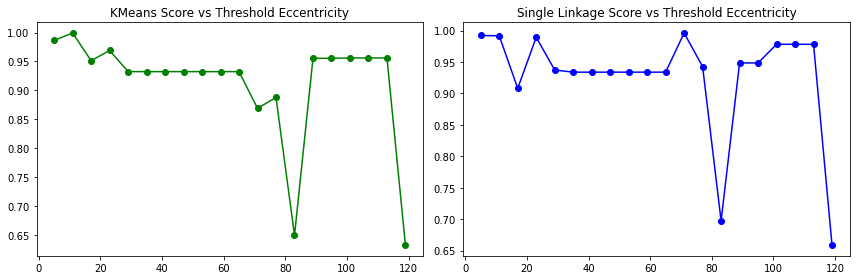

In [21]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].plot(eccentricity, kmeans_scores,'go-')
axs[0].set_title('KMeans Score vs Threshold Eccentricity')
axs[1].plot(eccentricity, linkage_scores, 'bo-')
axs[1].set_title('Single Linkage Score vs Threshold Eccentricity')
fig.tight_layout();

In [80]:
#overlap
SEED_NUM = 12

overlaps = np.linspace(0.0,0.5,num=20,endpoint = False)
kmeans_scores = []
linkage_scores = []

for o in overlaps:
    config = {
    "hawks": {
        "folder_name": "simple_example",
        "seed_num": SEED_NUM
    },
    "dataset": {
        "num_examples": 700,
        "num_clusters": 5
    },
    "constraints": {
        "overlap": {
            "threshold": o
        }
    }
    }
    generator = hawks.create_generator(config)
    generator.run()
    datasets, label_sets = generator.get_best_dataset()
    # Stored as a list for multiple runs
    data, labels = datasets[0], label_sets[0]
    # Run KMeans on the data
    km = KMeans(
    n_clusters=len(np.unique(labels)), random_state=SEED_NUM
    ).fit(data)
    ac = AgglomerativeClustering(
    n_clusters=len(np.unique(labels))).fit(data)
    
    kmeans_scores.append(adjusted_rand_score(labels, km.labels_))
    linkage_scores.append(adjusted_rand_score(labels, ac.labels_))
    


Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:05,  8.04it/s]

Generations:   4%|▍         | 2/49 [00:00<00:05,  8.46it/s]

Generations:   8%|▊         | 4/49 [00:00<00:05,  8.95it/s]

Generations:  10%|█         | 5/49 [00:00<00:04,  8.98it/s]

Generations:  12%|█▏        | 6/49 [00:00<00:04,  9.03it/s]

Generations:  14%|█▍        | 7/49 [00:00<00:04,  9.19it/s]

Generations:  16%|█▋        | 8/49 [00:00<00:04,  9.26it/s]

Generations:  18%|█▊        | 9/49 [00:00<00:04,  9.19it/s]

Generations:  20%|██        | 10/49 [00:01<00:04,  9.22it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:04,  8.62it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:04,  8.56it/s]

Generations:  27%|██▋       | 13/49 [00:01<00:04,  8.54it/s]

Generations:  29%|██▊       | 14/49 [00:01<00:03,  8.81it/s]

Generations:  33%|███▎      | 16/49 [00:01<00:03,  9.08it/s]

Generations:  35%|███▍      | 17/49 [00:01

Generations:  45%|████▍     | 22/49 [00:02<00:03,  8.91it/s]

Generations:  47%|████▋     | 23/49 [00:02<00:02,  8.91it/s]

Generations:  49%|████▉     | 24/49 [00:02<00:02,  9.06it/s]

Generations:  51%|█████     | 25/49 [00:02<00:02,  9.32it/s]

Generations:  53%|█████▎    | 26/49 [00:02<00:02,  9.21it/s]

Generations:  55%|█████▌    | 27/49 [00:02<00:02,  8.91it/s]

Generations:  57%|█████▋    | 28/49 [00:03<00:02,  9.09it/s]

Generations:  59%|█████▉    | 29/49 [00:03<00:02,  9.13it/s]

Generations:  61%|██████    | 30/49 [00:03<00:02,  9.18it/s]

Generations:  63%|██████▎   | 31/49 [00:03<00:02,  8.98it/s]

Generations:  65%|██████▌   | 32/49 [00:03<00:01,  8.97it/s]

Generations:  67%|██████▋   | 33/49 [00:03<00:01,  8.96it/s]

Generations:  69%|██████▉   | 34/49 [00:03<00:01,  9.15it/s]

Generations:  71%|███████▏  | 35/49 [00:03<00:01,  9.05it/s]

Generations:  73%|███████▎  | 36/49 [00:03<00:01,  8.93it/s]

Generations:  76%|███████▌  | 37/49 [00:04<00:01,  8.96it/s]

Generati

Generations:  92%|█████████▏| 45/49 [00:04<00:00,  8.92it/s]

Generations:  94%|█████████▍| 46/49 [00:05<00:00,  9.01it/s]

Generations:  96%|█████████▌| 47/49 [00:05<00:00,  8.71it/s]

Generations:  98%|█████████▊| 48/49 [00:05<00:00,  8.74it/s]

                                                            
Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:06,  7.18it/s]

Generations:   4%|▍         | 2/49 [00:00<00:06,  7.63it/s]

Generations:   8%|▊         | 4/49 [00:00<00:05,  8.18it/s]

Generations:  10%|█         | 5/49 [00:00<00:05,  8.42it/s]

Generations:  12%|█▏        | 6/49 [00:00<00:04,  8.64it/s]

Generations:  14%|█▍        | 7/49 [00:00<00:04,  8.78it/s]

Generations:  16%|█▋        | 8/49 [00:00<00:04,  8.63it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:04,  8.57it/s]

Generations:  20%|██        | 10/49 [00:01<00:04,  8.79it/s]

Generations:  22%|██▏       | 11/49 [00:01<

Generations:  24%|██▍       | 12/49 [00:01<00:04,  8.88it/s]

Generations:  27%|██▋       | 13/49 [00:01<00:04,  8.75it/s]

Generations:  29%|██▊       | 14/49 [00:01<00:04,  8.74it/s]

Generations:  31%|███       | 15/49 [00:01<00:03,  8.54it/s]

Generations:  33%|███▎      | 16/49 [00:01<00:03,  8.51it/s]

Generations:  35%|███▍      | 17/49 [00:01<00:03,  8.74it/s]

Generations:  37%|███▋      | 18/49 [00:02<00:03,  8.85it/s]

Generations:  39%|███▉      | 19/49 [00:02<00:03,  8.98it/s]

Generations:  41%|████      | 20/49 [00:02<00:03,  9.14it/s]

Generations:  45%|████▍     | 22/49 [00:02<00:02,  9.32it/s]

Generations:  49%|████▉     | 24/49 [00:02<00:02,  9.38it/s]

Generations:  51%|█████     | 25/49 [00:02<00:02,  9.25it/s]

Generations:  53%|█████▎    | 26/49 [00:02<00:02,  9.34it/s]

Generations:  55%|█████▌    | 27/49 [00:03<00:02,  9.30it/s]

Generations:  57%|█████▋    | 28/49 [00:03<00:02,  8.90it/s]

Generations:  59%|█████▉    | 29/49 [00:03<00:02,  8.90it/s]

Generati

Generations:  78%|███████▊  | 38/49 [00:04<00:01,  9.80it/s]

Generations:  80%|███████▉  | 39/49 [00:04<00:01,  9.40it/s]

Generations:  82%|████████▏ | 40/49 [00:04<00:00,  9.49it/s]

Generations:  86%|████████▌ | 42/49 [00:04<00:00,  9.76it/s]

Generations:  88%|████████▊ | 43/49 [00:04<00:00,  9.76it/s]

Generations:  90%|████████▉ | 44/49 [00:04<00:00,  9.33it/s]

Generations:  92%|█████████▏| 45/49 [00:04<00:00,  9.30it/s]

Generations:  96%|█████████▌| 47/49 [00:05<00:00,  9.55it/s]

Generations:  98%|█████████▊| 48/49 [00:05<00:00,  9.52it/s]

Generations: 100%|██████████| 49/49 [00:05<00:00,  9.49it/s]

                                                            
Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:05,  8.44it/s]

Generations:   4%|▍         | 2/49 [00:00<00:05,  8.84it/s]

Generations:   8%|▊         | 4/49 [00:00<00:04,  9.14it/s]

Generations:  10%|█         | 5/49 [00

Generations:  29%|██▊       | 14/49 [00:01<00:03,  9.24it/s]

Generations:  31%|███       | 15/49 [00:01<00:03,  9.16it/s]

Generations:  33%|███▎      | 16/49 [00:01<00:03,  9.39it/s]

Generations:  35%|███▍      | 17/49 [00:01<00:03,  9.10it/s]

Generations:  37%|███▋      | 18/49 [00:01<00:03,  9.00it/s]

Generations:  39%|███▉      | 19/49 [00:02<00:03,  9.02it/s]

Generations:  41%|████      | 20/49 [00:02<00:03,  9.05it/s]

Generations:  43%|████▎     | 21/49 [00:02<00:03,  9.19it/s]

Generations:  45%|████▍     | 22/49 [00:02<00:02,  9.37it/s]

Generations:  47%|████▋     | 23/49 [00:02<00:02,  9.33it/s]

Generations:  49%|████▉     | 24/49 [00:02<00:02,  9.36it/s]

Generations:  51%|█████     | 25/49 [00:02<00:02,  9.41it/s]

Generations:  53%|█████▎    | 26/49 [00:02<00:02,  9.21it/s]

Generations:  55%|█████▌    | 27/49 [00:02<00:02,  9.15it/s]

Generations:  57%|█████▋    | 28/49 [00:03<00:02,  9.29it/s]

Generations:  59%|█████▉    | 29/49 [00:03<00:02,  9.40it/s]

Generati

Generations:  84%|████████▎ | 41/49 [00:04<00:00,  8.36it/s]

Generations:  86%|████████▌ | 42/49 [00:04<00:00,  8.20it/s]

Generations:  88%|████████▊ | 43/49 [00:04<00:00,  8.43it/s]

Generations:  90%|████████▉ | 44/49 [00:04<00:00,  8.46it/s]

Generations:  92%|█████████▏| 45/49 [00:04<00:00,  8.82it/s]

Generations:  96%|█████████▌| 47/49 [00:05<00:00,  9.08it/s]

Generations: 100%|██████████| 49/49 [00:05<00:00,  9.38it/s]

                                                            
Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:06,  7.54it/s]

Generations:   4%|▍         | 2/49 [00:00<00:05,  7.99it/s]

Generations:   8%|▊         | 4/49 [00:00<00:05,  8.53it/s]

Generations:  10%|█         | 5/49 [00:00<00:05,  8.75it/s]

Generations:  12%|█▏        | 6/49 [00:00<00:04,  9.02it/s]

Generations:  14%|█▍        | 7/49 [00:00<00:05,  7.85it/s]

Generations:  16%|█▋        | 8/49 [00:00

Generations:  57%|█████▋    | 28/49 [00:02<00:02,  9.38it/s]

Generations:  59%|█████▉    | 29/49 [00:03<00:02,  9.30it/s]

Generations:  61%|██████    | 30/49 [00:03<00:02,  9.47it/s]

Generations:  63%|██████▎   | 31/49 [00:03<00:01,  9.52it/s]

Generations:  65%|██████▌   | 32/49 [00:03<00:01,  9.61it/s]

Generations:  67%|██████▋   | 33/49 [00:03<00:01,  9.56it/s]

Generations:  69%|██████▉   | 34/49 [00:03<00:01,  9.63it/s]

Generations:  73%|███████▎  | 36/49 [00:03<00:01,  9.82it/s]

Generations:  76%|███████▌  | 37/49 [00:03<00:01,  9.69it/s]

Generations:  80%|███████▉  | 39/49 [00:04<00:01,  9.58it/s]

Generations:  82%|████████▏ | 40/49 [00:04<00:00,  9.59it/s]

Generations:  84%|████████▎ | 41/49 [00:04<00:00,  9.28it/s]

Generations:  86%|████████▌ | 42/49 [00:04<00:00,  9.36it/s]

Generations:  88%|████████▊ | 43/49 [00:04<00:00,  9.48it/s]

Generations:  90%|████████▉ | 44/49 [00:04<00:00,  9.31it/s]

Generations:  92%|█████████▏| 45/49 [00:04<00:00,  9.34it/s]

Generati

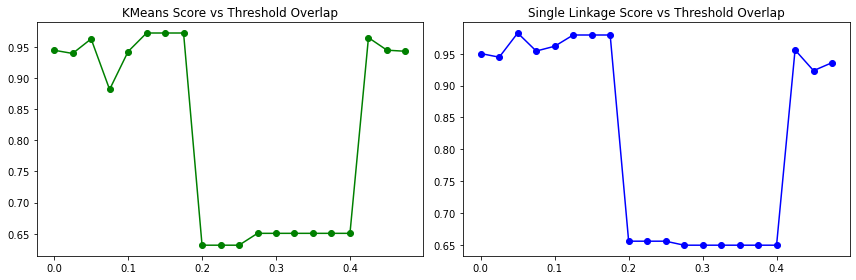

In [8]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].plot(overlaps, kmeans_scores,'go-')
axs[0].set_title('KMeans Score vs Threshold Overlap')
axs[1].plot(overlaps, linkage_scores, 'bo-')
axs[1].set_title('Single Linkage Score vs Threshold Overlap')
fig.tight_layout();

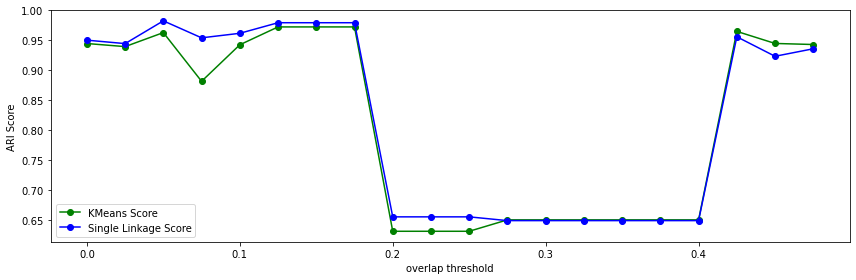

In [83]:
fig,axs = plt.subplots(figsize=(12, 4))
axs.plot(overlaps, kmeans_scores,'go-', label='KMeans Score')
axs.plot(overlaps, linkage_scores, 'bo-', label='Single Linkage Score')
axs.set_xlabel("overlap threshold")
axs.set_ylabel("ARI Score")
axs.legend()
fig.tight_layout();

In [73]:
SEED_NUM = 42
config = {
    "hawks": {
        "folder_name": "simple_example",
        "seed_num": SEED_NUM,
        "num_runs": 10,
    },
    "objectives": {
        "silhouette": {
            "target": 0.8
        }
    },
    "dataset": {
        "num_examples": 1000,
        "num_clusters": 4
    },
    "constraints": {
        "overlap": {
            "threshold": [0.0, 0.2, 0.5, 1.0],
            "limit": "upper"
        }
    }
}
# list(np.linspace(0.0,1,num=20))
generator = hawks.create_generator(config)
generator.run()

Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:09,  4.96it/s]

Generations:   4%|▍         | 2/49 [00:00<00:09,  5.17it/s]

Generations:   6%|▌         | 3/49 [00:00<00:08,  5.28it/s]

Generations:   8%|▊         | 4/49 [00:00<00:08,  5.39it/s]

Generations:  10%|█         | 5/49 [00:00<00:08,  5.39it/s]

Generations:  12%|█▏        | 6/49 [00:01<00:07,  5.63it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.70it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:07,  5.76it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:07,  5.69it/s]

Generations:  20%|██        | 10/49 [00:01<00:07,  5.54it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  5.72it/s]

Generations:  24%|██▍       | 12/49 [00:02<00:06,  5.79it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:06,  5.67it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:06,  5.47it/s]

Generations:  31%|███       | 15/49 [00:02

Generations:  33%|███▎      | 16/49 [00:02<00:06,  5.17it/s]

Generations:  35%|███▍      | 17/49 [00:03<00:06,  5.02it/s]

Generations:  37%|███▋      | 18/49 [00:03<00:06,  5.09it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:05,  5.27it/s]

Generations:  41%|████      | 20/49 [00:03<00:05,  5.33it/s]

Generations:  43%|████▎     | 21/49 [00:03<00:05,  5.41it/s]

Generations:  45%|████▍     | 22/49 [00:04<00:04,  5.57it/s]

Generations:  47%|████▋     | 23/49 [00:04<00:04,  5.72it/s]

Generations:  49%|████▉     | 24/49 [00:04<00:04,  5.74it/s]

Generations:  51%|█████     | 25/49 [00:04<00:04,  5.56it/s]

Generations:  53%|█████▎    | 26/49 [00:04<00:04,  5.65it/s]

Generations:  55%|█████▌    | 27/49 [00:04<00:03,  5.60it/s]

Generations:  57%|█████▋    | 28/49 [00:05<00:03,  5.29it/s]

Generations:  59%|█████▉    | 29/49 [00:05<00:03,  5.46it/s]

Generations:  61%|██████    | 30/49 [00:05<00:03,  5.54it/s]

Generations:  63%|██████▎   | 31/49 [00:05<00:03,  5.42it/s]

Generati

Generations:  67%|██████▋   | 33/49 [00:05<00:02,  5.77it/s]

Generations:  69%|██████▉   | 34/49 [00:05<00:02,  6.01it/s]

Generations:  71%|███████▏  | 35/49 [00:05<00:02,  5.82it/s]

Generations:  73%|███████▎  | 36/49 [00:05<00:02,  5.95it/s]

Generations:  76%|███████▌  | 37/49 [00:06<00:02,  5.87it/s]

Generations:  78%|███████▊  | 38/49 [00:06<00:01,  5.85it/s]

Generations:  80%|███████▉  | 39/49 [00:06<00:01,  5.93it/s]

Generations:  82%|████████▏ | 40/49 [00:06<00:01,  5.98it/s]

Generations:  84%|████████▎ | 41/49 [00:06<00:01,  6.21it/s]

Generations:  86%|████████▌ | 42/49 [00:06<00:01,  6.30it/s]

Generations:  88%|████████▊ | 43/49 [00:07<00:00,  6.32it/s]

Generations:  90%|████████▉ | 44/49 [00:07<00:00,  6.07it/s]

Generations:  92%|█████████▏| 45/49 [00:07<00:00,  6.11it/s]

Generations:  94%|█████████▍| 46/49 [00:07<00:00,  5.96it/s]

Generations:  96%|█████████▌| 47/49 [00:07<00:00,  6.25it/s]

Generations:  98%|█████████▊| 48/49 [00:07<00:00,  6.36it/s]

Generati

                                                            
Runs:  70%|███████   | 7/10 [01:00<00:25,  8.61s/it]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:08,  5.42it/s]

Generations:   4%|▍         | 2/49 [00:00<00:08,  5.76it/s]

Generations:   6%|▌         | 3/49 [00:00<00:08,  5.67it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  5.78it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.64it/s]

Generations:  12%|█▏        | 6/49 [00:01<00:07,  5.70it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.88it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:06,  5.87it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  5.83it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  6.08it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  6.18it/s]

Generations:  24%|██▍       | 12/49 [00:02<00:05,  6.21it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.32it/s]

Generations:  29%|██▊       | 14/49

Generations:  31%|███       | 15/49 [00:02<00:05,  6.05it/s]

Generations:  33%|███▎      | 16/49 [00:02<00:05,  6.25it/s]

Generations:  35%|███▍      | 17/49 [00:02<00:05,  6.30it/s]

Generations:  37%|███▋      | 18/49 [00:03<00:04,  6.40it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:04,  6.46it/s]

Generations:  41%|████      | 20/49 [00:03<00:04,  6.47it/s]

Generations:  43%|████▎     | 21/49 [00:03<00:04,  6.45it/s]

Generations:  45%|████▍     | 22/49 [00:03<00:04,  6.51it/s]

Generations:  47%|████▋     | 23/49 [00:03<00:03,  6.61it/s]

Generations:  49%|████▉     | 24/49 [00:03<00:03,  6.45it/s]

Generations:  51%|█████     | 25/49 [00:04<00:03,  6.39it/s]

Generations:  53%|█████▎    | 26/49 [00:04<00:03,  6.48it/s]

Generations:  55%|█████▌    | 27/49 [00:04<00:03,  6.32it/s]

Generations:  57%|█████▋    | 28/49 [00:04<00:03,  6.30it/s]

Generations:  59%|█████▉    | 29/49 [00:04<00:03,  6.50it/s]

Generations:  61%|██████    | 30/49 [00:04<00:02,  6.41it/s]

Generati

Generations:  61%|██████    | 30/49 [00:04<00:03,  6.19it/s]

Generations:  63%|██████▎   | 31/49 [00:05<00:02,  6.22it/s]

Generations:  65%|██████▌   | 32/49 [00:05<00:02,  6.07it/s]

Generations:  67%|██████▋   | 33/49 [00:05<00:02,  6.22it/s]

Generations:  69%|██████▉   | 34/49 [00:05<00:02,  6.41it/s]

Generations:  71%|███████▏  | 35/49 [00:05<00:02,  6.26it/s]

Generations:  73%|███████▎  | 36/49 [00:05<00:02,  6.09it/s]

Generations:  76%|███████▌  | 37/49 [00:06<00:01,  6.17it/s]

Generations:  78%|███████▊  | 38/49 [00:06<00:01,  6.22it/s]

Generations:  80%|███████▉  | 39/49 [00:06<00:01,  6.09it/s]

Generations:  82%|████████▏ | 40/49 [00:06<00:01,  6.19it/s]

Generations:  84%|████████▎ | 41/49 [00:06<00:01,  6.15it/s]

Generations:  86%|████████▌ | 42/49 [00:06<00:01,  6.02it/s]

Generations:  88%|████████▊ | 43/49 [00:07<00:00,  6.12it/s]

Generations:  90%|████████▉ | 44/49 [00:07<00:00,  6.18it/s]

Generations:  92%|█████████▏| 45/49 [00:07<00:00,  6.40it/s]

Generati

Generations:  96%|█████████▌| 47/49 [00:08<00:00,  6.05it/s]

Generations:  98%|█████████▊| 48/49 [00:08<00:00,  5.60it/s]

Generations: 100%|██████████| 49/49 [00:08<00:00,  5.33it/s]

                                                            
Runs:  40%|████      | 4/10 [00:34<00:52,  8.68s/it]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:07,  6.17it/s]

Generations:   4%|▍         | 2/49 [00:00<00:07,  6.10it/s]

Generations:   6%|▌         | 3/49 [00:00<00:07,  5.99it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  5.77it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.81it/s]

Generations:  12%|█▏        | 6/49 [00:01<00:07,  6.09it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:06,  6.08it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:07,  5.80it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  5.76it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  6.08it/s]

Generations:  22%|██▏       | 11/49

Generations:  24%|██▍       | 12/49 [00:02<00:06,  5.84it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:06,  5.72it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:06,  5.67it/s]

Generations:  31%|███       | 15/49 [00:02<00:05,  5.70it/s]

Generations:  33%|███▎      | 16/49 [00:02<00:05,  5.67it/s]

Generations:  35%|███▍      | 17/49 [00:02<00:05,  5.75it/s]

Generations:  37%|███▋      | 18/49 [00:03<00:05,  5.62it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:05,  5.61it/s]

Generations:  41%|████      | 20/49 [00:03<00:05,  5.70it/s]

Generations:  43%|████▎     | 21/49 [00:03<00:04,  5.79it/s]

Generations:  45%|████▍     | 22/49 [00:03<00:04,  5.85it/s]

Generations:  47%|████▋     | 23/49 [00:03<00:04,  6.10it/s]

Generations:  49%|████▉     | 24/49 [00:04<00:04,  5.94it/s]

Generations:  51%|█████     | 25/49 [00:04<00:04,  5.76it/s]

Generations:  53%|█████▎    | 26/49 [00:04<00:03,  5.76it/s]

Generations:  55%|█████▌    | 27/49 [00:04<00:03,  5.67it/s]

Generati

Generations:  59%|█████▉    | 29/49 [00:04<00:03,  6.02it/s]

Generations:  61%|██████    | 30/49 [00:04<00:03,  5.96it/s]

Generations:  63%|██████▎   | 31/49 [00:05<00:02,  6.06it/s]

Generations:  65%|██████▌   | 32/49 [00:05<00:02,  5.98it/s]

Generations:  67%|██████▋   | 33/49 [00:05<00:02,  5.98it/s]

Generations:  69%|██████▉   | 34/49 [00:05<00:02,  5.75it/s]

Generations:  71%|███████▏  | 35/49 [00:05<00:02,  5.85it/s]

Generations:  73%|███████▎  | 36/49 [00:05<00:02,  6.24it/s]

Generations:  76%|███████▌  | 37/49 [00:06<00:01,  6.07it/s]

Generations:  78%|███████▊  | 38/49 [00:06<00:01,  6.22it/s]

Generations:  80%|███████▉  | 39/49 [00:06<00:01,  6.32it/s]

Generations:  82%|████████▏ | 40/49 [00:06<00:01,  6.29it/s]

Generations:  84%|████████▎ | 41/49 [00:06<00:01,  6.28it/s]

Generations:  86%|████████▌ | 42/49 [00:06<00:01,  6.32it/s]

Generations:  88%|████████▊ | 43/49 [00:07<00:00,  6.43it/s]

Generations:  90%|████████▉ | 44/49 [00:07<00:00,  6.41it/s]

Generati

Generations:  90%|████████▉ | 44/49 [00:07<00:00,  6.33it/s]

Generations:  92%|█████████▏| 45/49 [00:07<00:00,  6.26it/s]

Generations:  94%|█████████▍| 46/49 [00:07<00:00,  6.24it/s]

Generations:  96%|█████████▌| 47/49 [00:07<00:00,  6.53it/s]

Generations:  98%|█████████▊| 48/49 [00:07<00:00,  6.69it/s]

Generations: 100%|██████████| 49/49 [00:07<00:00,  6.56it/s]

                                                            
Runs:  10%|█         | 1/10 [00:08<01:13,  8.14s/it]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:08,  5.46it/s]

Generations:   4%|▍         | 2/49 [00:00<00:08,  5.61it/s]

Generations:   6%|▌         | 3/49 [00:00<00:07,  5.80it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  5.87it/s]

Generations:  10%|█         | 5/49 [00:00<00:07,  5.99it/s]

Generations:  12%|█▏        | 6/49 [00:01<00:07,  5.95it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:06,  6.25it/s]

Generations:  16%|█▋        | 8/4

Generations:  18%|█▊        | 9/49 [00:01<00:06,  6.19it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  6.10it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  6.26it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:05,  6.31it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.15it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:05,  6.14it/s]

Generations:  31%|███       | 15/49 [00:02<00:05,  6.32it/s]

Generations:  33%|███▎      | 16/49 [00:02<00:05,  6.09it/s]

Generations:  35%|███▍      | 17/49 [00:02<00:05,  6.18it/s]

Generations:  37%|███▋      | 18/49 [00:02<00:04,  6.28it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:04,  6.09it/s]

Generations:  41%|████      | 20/49 [00:03<00:04,  6.08it/s]

Generations:  43%|████▎     | 21/49 [00:03<00:04,  6.18it/s]

Generations:  45%|████▍     | 22/49 [00:03<00:04,  6.20it/s]

Generations:  47%|████▋     | 23/49 [00:03<00:04,  6.04it/s]

Generations:  49%|████▉     | 24/49 [00:03<00:04,  6.25it/s]

Generatio

Generations:  53%|█████▎    | 26/49 [00:04<00:04,  5.67it/s]

Generations:  55%|█████▌    | 27/49 [00:04<00:03,  5.62it/s]

Generations:  57%|█████▋    | 28/49 [00:04<00:03,  5.78it/s]

Generations:  59%|█████▉    | 29/49 [00:05<00:03,  5.56it/s]

Generations:  61%|██████    | 30/49 [00:05<00:03,  5.33it/s]

Generations:  63%|██████▎   | 31/49 [00:05<00:03,  5.56it/s]

Generations:  65%|██████▌   | 32/49 [00:05<00:03,  5.52it/s]

Generations:  67%|██████▋   | 33/49 [00:05<00:02,  5.73it/s]

Generations:  69%|██████▉   | 34/49 [00:06<00:02,  5.73it/s]

Generations:  71%|███████▏  | 35/49 [00:06<00:02,  5.85it/s]

Generations:  73%|███████▎  | 36/49 [00:06<00:02,  5.61it/s]

Generations:  76%|███████▌  | 37/49 [00:06<00:02,  5.55it/s]

Generations:  78%|███████▊  | 38/49 [00:06<00:01,  5.52it/s]

Generations:  80%|███████▉  | 39/49 [00:06<00:01,  5.39it/s]

Generations:  82%|████████▏ | 40/49 [00:07<00:01,  5.39it/s]

Generations:  84%|████████▎ | 41/49 [00:07<00:01,  5.50it/s]

Generati

Generations:  88%|████████▊ | 43/49 [00:07<00:00,  6.37it/s]

Generations:  90%|████████▉ | 44/49 [00:07<00:00,  6.28it/s]

Generations:  92%|█████████▏| 45/49 [00:07<00:00,  6.25it/s]

Generations:  94%|█████████▍| 46/49 [00:07<00:00,  6.29it/s]

Generations:  96%|█████████▌| 47/49 [00:07<00:00,  6.44it/s]

Generations:  98%|█████████▊| 48/49 [00:07<00:00,  6.23it/s]

Generations: 100%|██████████| 49/49 [00:08<00:00,  6.12it/s]

                                                            
Runs:  80%|████████  | 8/10 [01:07<00:16,  8.46s/it]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:12,  3.86it/s]

Generations:   4%|▍         | 2/49 [00:00<00:11,  4.16it/s]

Generations:   6%|▌         | 3/49 [00:00<00:10,  4.51it/s]

Generations:   8%|▊         | 4/49 [00:00<00:09,  4.84it/s]

Generations:  10%|█         | 5/49 [00:00<00:08,  5.29it/s]

Generations:  12%|█▏        | 6/49 [00:01<00:07,  5.61it/s]

Generations:  14%|█▍        | 7/

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.99it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:06,  6.02it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  6.08it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  6.07it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  6.15it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:05,  6.24it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.44it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:05,  6.42it/s]

Generations:  31%|███       | 15/49 [00:02<00:05,  6.39it/s]

Generations:  33%|███▎      | 16/49 [00:02<00:05,  6.29it/s]

Generations:  35%|███▍      | 17/49 [00:02<00:05,  6.30it/s]

Generations:  37%|███▋      | 18/49 [00:02<00:04,  6.37it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:04,  6.47it/s]

Generations:  41%|████      | 20/49 [00:03<00:04,  6.50it/s]

Generations:  43%|████▎     | 21/49 [00:03<00:04,  6.52it/s]

Generations:  45%|████▍     | 22/49 [00:03<00:04,  6.25it/s]

Generations

Generations:  49%|████▉     | 24/49 [00:04<00:03,  6.25it/s]

Generations:  51%|█████     | 25/49 [00:04<00:04,  5.99it/s]

Generations:  53%|█████▎    | 26/49 [00:04<00:03,  6.00it/s]

Generations:  55%|█████▌    | 27/49 [00:04<00:03,  5.96it/s]

Generations:  57%|█████▋    | 28/49 [00:04<00:03,  6.01it/s]

Generations:  59%|█████▉    | 29/49 [00:04<00:03,  6.15it/s]

Generations:  61%|██████    | 30/49 [00:05<00:03,  6.02it/s]

Generations:  63%|██████▎   | 31/49 [00:05<00:03,  5.87it/s]

Generations:  65%|██████▌   | 32/49 [00:05<00:02,  5.85it/s]

Generations:  67%|██████▋   | 33/49 [00:05<00:02,  5.95it/s]

Generations:  69%|██████▉   | 34/49 [00:05<00:02,  6.15it/s]

Generations:  71%|███████▏  | 35/49 [00:05<00:02,  6.35it/s]

Generations:  73%|███████▎  | 36/49 [00:06<00:02,  6.14it/s]

Generations:  76%|███████▌  | 37/49 [00:06<00:01,  6.09it/s]

Generations:  78%|███████▊  | 38/49 [00:06<00:01,  5.83it/s]

Generations:  80%|███████▉  | 39/49 [00:06<00:01,  5.85it/s]

Generati

Generations:  84%|████████▎ | 41/49 [00:07<00:01,  5.39it/s]

Generations:  86%|████████▌ | 42/49 [00:07<00:01,  5.32it/s]

Generations:  88%|████████▊ | 43/49 [00:07<00:01,  5.49it/s]

Generations:  90%|████████▉ | 44/49 [00:07<00:00,  5.45it/s]

Generations:  92%|█████████▏| 45/49 [00:08<00:00,  5.50it/s]

Generations:  94%|█████████▍| 46/49 [00:08<00:00,  5.62it/s]

Generations:  96%|█████████▌| 47/49 [00:08<00:00,  5.62it/s]

Generations:  98%|█████████▊| 48/49 [00:08<00:00,  5.74it/s]

Generations: 100%|██████████| 49/49 [00:08<00:00,  5.60it/s]

                                                            
Runs:  50%|█████     | 5/10 [00:43<00:43,  8.70s/it]

Generations:   0%|          | 0/49 [00:00<?, ?it/s]

Generations:   2%|▏         | 1/49 [00:00<00:08,  5.87it/s]

Generations:   4%|▍         | 2/49 [00:00<00:07,  5.97it/s]

Generations:   6%|▌         | 3/49 [00:00<00:07,  6.04it/s]

Generations:   8%|▊         | 4/49 [00:00<00:07,  6.04it/s]

Generations:  10%|█         | 

Generations:  12%|█▏        | 6/49 [00:01<00:07,  5.91it/s]

Generations:  14%|█▍        | 7/49 [00:01<00:07,  5.87it/s]

Generations:  16%|█▋        | 8/49 [00:01<00:06,  6.04it/s]

Generations:  18%|█▊        | 9/49 [00:01<00:06,  6.04it/s]

Generations:  20%|██        | 10/49 [00:01<00:06,  6.15it/s]

Generations:  22%|██▏       | 11/49 [00:01<00:06,  6.16it/s]

Generations:  24%|██▍       | 12/49 [00:01<00:05,  6.23it/s]

Generations:  27%|██▋       | 13/49 [00:02<00:05,  6.07it/s]

Generations:  29%|██▊       | 14/49 [00:02<00:05,  6.21it/s]

Generations:  31%|███       | 15/49 [00:02<00:05,  6.10it/s]

Generations:  33%|███▎      | 16/49 [00:02<00:05,  5.88it/s]

Generations:  35%|███▍      | 17/49 [00:02<00:05,  5.90it/s]

Generations:  37%|███▋      | 18/49 [00:03<00:05,  5.93it/s]

Generations:  39%|███▉      | 19/49 [00:03<00:05,  5.81it/s]

Generations:  41%|████      | 20/49 [00:03<00:04,  5.95it/s]

Generations:  43%|████▎     | 21/49 [00:03<00:05,  5.38it/s]

Generations:

Generations:  47%|████▋     | 23/49 [00:03<00:04,  6.40it/s]

Generations:  49%|████▉     | 24/49 [00:03<00:03,  6.44it/s]

Generations:  51%|█████     | 25/49 [00:04<00:03,  6.62it/s]

Generations:  53%|█████▎    | 26/49 [00:04<00:03,  6.71it/s]

Generations:  55%|█████▌    | 27/49 [00:04<00:03,  6.68it/s]

Generations:  57%|█████▋    | 28/49 [00:04<00:03,  6.52it/s]

Generations:  59%|█████▉    | 29/49 [00:04<00:03,  6.53it/s]

Generations:  61%|██████    | 30/49 [00:04<00:02,  6.72it/s]

Generations:  63%|██████▎   | 31/49 [00:04<00:02,  6.51it/s]

Generations:  65%|██████▌   | 32/49 [00:05<00:02,  6.38it/s]

Generations:  67%|██████▋   | 33/49 [00:05<00:02,  6.53it/s]

Generations:  69%|██████▉   | 34/49 [00:05<00:02,  6.26it/s]

Generations:  71%|███████▏  | 35/49 [00:05<00:02,  6.18it/s]

Generations:  73%|███████▎  | 36/49 [00:05<00:02,  6.32it/s]

Generations:  76%|███████▌  | 37/49 [00:05<00:01,  6.36it/s]

Generations:  78%|███████▊  | 38/49 [00:06<00:01,  6.47it/s]

Generati

In [74]:
# Analyse the hawks datasets
df, _ = hawks.analysis.analyse_datasets(
    generator=generator,
    source="HAWKS",
    seed=SEED_NUM,
    save=False
)
df = df.set_index("config_num")
df.head(4)

,source,dataset_num,num_examples,num_clusters,c_Average-Linkage,c_Average-Linkage (2K),c_GMM,c_K-Means++,c_Single-Linkage,c_Single-Linkage (2K),f_dimensionality,f_overlap,f_silhouette
config_num,,,,,,,,,,,,,
0,HAWKS,0,1001,4,0.986478,0.953101,1.000000,0.959766,0.077791,0.996020,2,0.000999,0.799324
0,HAWKS,1,1000,4,0.906001,0.911616,1.000000,0.560992,0.908837,0.997928,2,0.000000,0.799929
0,HAWKS,2,1001,4,0.546438,0.967793,1.000000,0.983804,0.135160,0.142466,2,0.000000,0.800147
0,HAWKS,3,1000,4,0.664737,0.893358,0.987204,0.965055,0.205293,0.208062,2,0.013000,0.799695


In [75]:
df_best = generator.stats[generator.stats["best_indiv"] ==1].set_index("config_id")
overlap_threshold_Serie = df_best.overlap_threshold
overlap_threshold_Serie.index.names = ["config_num"]
df.insert(4, "overlap_threshold", overlap_threshold_Serie)
df.head(4)

,source,dataset_num,num_examples,num_clusters,overlap_threshold,c_Average-Linkage,c_Average-Linkage (2K),c_GMM,c_K-Means++,c_Single-Linkage,c_Single-Linkage (2K),f_dimensionality,f_overlap,f_silhouette
config_num,,,,,,,,,,,,,,
0,HAWKS,0,1001,4,0.0,0.986478,0.953101,1.000000,0.959766,0.077791,0.996020,2,0.000999,0.799324
0,HAWKS,1,1000,4,0.0,0.906001,0.911616,1.000000,0.560992,0.908837,0.997928,2,0.000000,0.799929
0,HAWKS,2,1001,4,0.0,0.546438,0.967793,1.000000,0.983804,0.135160,0.142466,2,0.000000,0.800147
0,HAWKS,3,1000,4,0.0,0.664737,0.893358,0.987204,0.965055,0.205293,0.208062,2,0.013000,0.799695


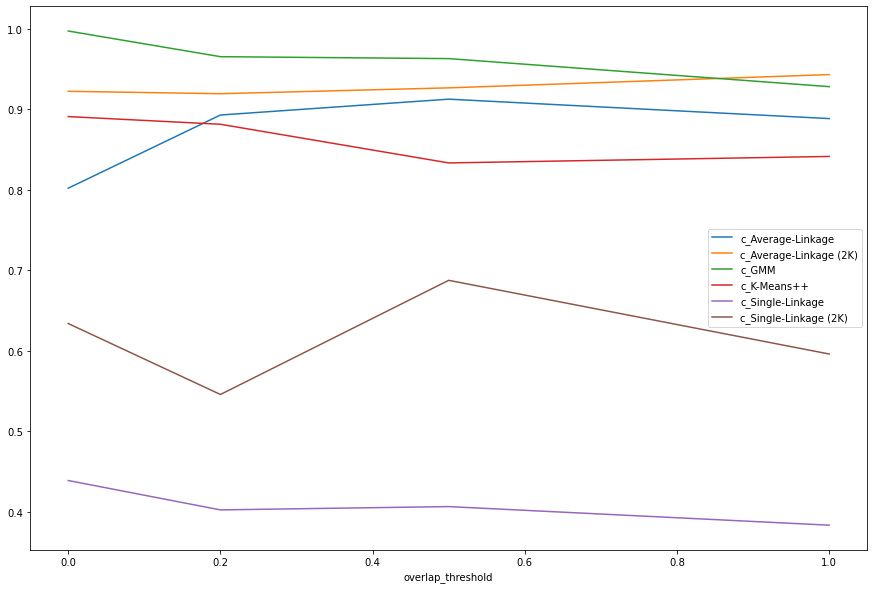

In [76]:
df.groupby("config_num").mean().set_index("overlap_threshold")[["c_Average-Linkage", "c_Average-Linkage (2K)", "c_GMM", "c_K-Means++", "c_Single-Linkage", "c_Single-Linkage (2K)"]].plot(
figsize=(15,10)
)

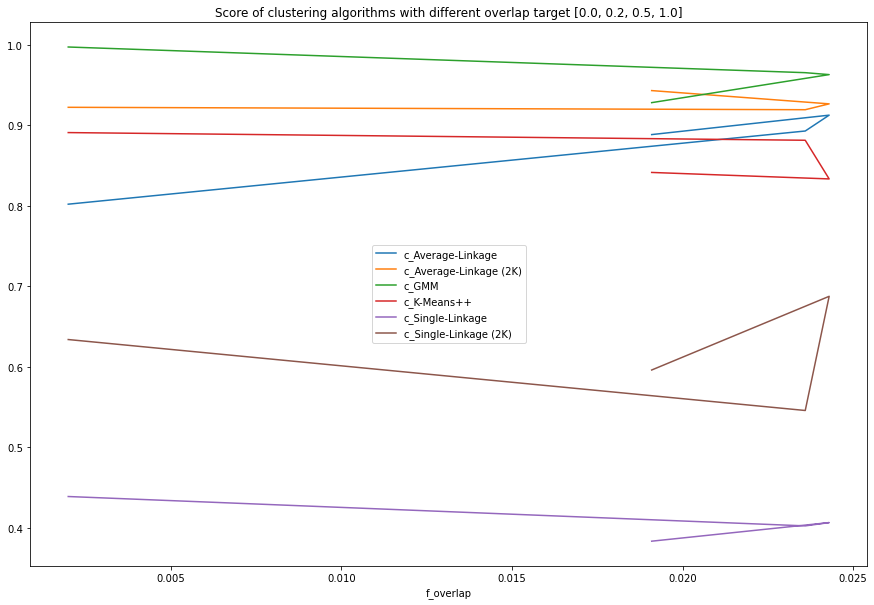

In [79]:
df.groupby("config_num").mean().set_index("f_overlap")[["c_Average-Linkage", "c_Average-Linkage (2K)", "c_GMM", "c_K-Means++", "c_Single-Linkage", "c_Single-Linkage (2K)"]].plot(
figsize=(15,10), title="Score of clustering algorithms with different overlap target [0.0, 0.2, 0.5, 1.0]"
)

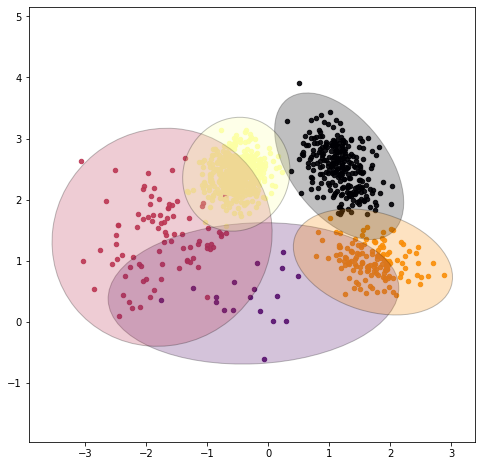

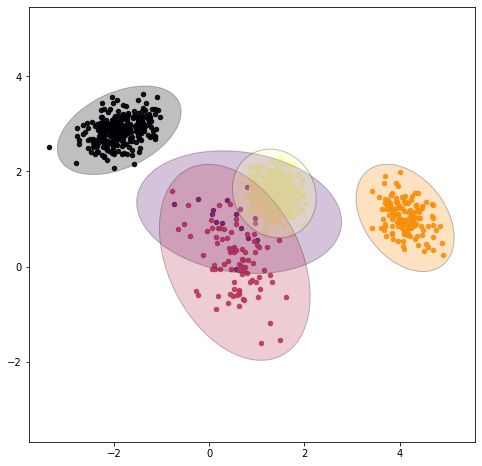

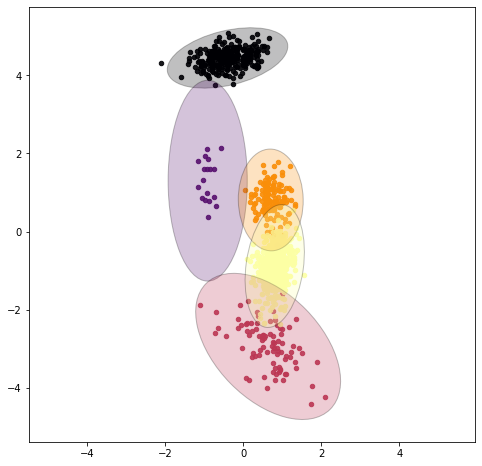

In [70]:
generator.plot_best_indivs(show=True)

In [70]:
datasets, label_sets = generator.get_best_dataset()
# Stored as a list for multiple runs
data, labels = datasets[0], label_sets[0]
# Analyse the hawks datasets
df, _ = hawks.analysis.analyse_datasets(
    generator=generator,
    source="HAWKS",
    seed=SEED_NUM,
    save=False
)
df

,source,config_num,dataset_num,num_examples,num_clusters,c_Average-Linkage,c_Average-Linkage (2K),c_GMM,c_K-Means++,c_Single-Linkage,c_Single-Linkage (2K),f_dimensionality,f_overlap,f_silhouette
0,HAWKS,0,0,1001,4,0.374098,0.730663,0.649126,0.639915,0.384712,0.385040,2,0.050949,0.286097
1,HAWKS,1,1,1001,4,0.863903,0.493204,0.637527,0.621827,0.000384,-0.000603,2,0.056943,0.496471
2,HAWKS,2,2,1001,4,0.986478,0.953101,1.000000,0.959766,0.077791,0.996020,2,0.000999,0.799324


### The stochastic ranking parameter $P_f$ 


<center><img src='img/Fig6.png'></center>

## Result from the paper

<center><img src='img/Table1.png'></center>

<center><img src='img/Fig7and8.png'></center>